In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [39]:
data = pd.read_csv('../../data/panel_data.csv')
data['year'] = [element.split('-')[0] for element in data['time']]
data['month'] = [element.split('-')[1] for element in data['time']]
data.head()

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,year,month
0,2020-01-01,TIBESTI,13.226863,0.006183,0.010336,0.264653,15.0,0.0,2020,01
1,2020-01-01,BORKOU,17.938311,0.001743,0.013868,0.356516,80.0,0.0,2020,01
2,2020-01-01,ENNEDI OUEST,14.834963,0.001229,0.053228,0.344716,58.0,0.0,2020,01
3,2020-01-01,WADI FIRA,18.471732,0.001052,0.268617,0.859191,600.0,0.0,2020,01
4,2020-01-01,SALAMAT,25.261679,0.001052,0.567471,1.311763,621.0,3.0,2020,01


# ACF and PACF

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df is your dataframe with 'time', 'entity', and 'cases' columns
entities = data['state'].unique()  # Get unique entities in the panel
n_entities = len(entities)  # Number of entities
ncols = 4  # Number of columns in the plot grid
nrows = (n_entities * 2 // ncols) + (n_entities * 2 % ncols > 0)   # Number of rows

# Create subplots
def plt_acfs(varname, entities, nrows, ncols, data):
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 2))  # Adjust figure size as needed
    axs = axs.flatten()  # Flatten the 2D array of axes to iterate easily

    for i, entity in enumerate(entities):
        entity_data = data[data['state'] == entity].sort_values(by='time')[varname]  # Filter and sort data by time
        
        # Plot ACF
        plot_acf(entity_data, lags=20, ax=axs[i * 2])  # ACF plot
        axs[i * 2].set_title(f'ACF for {entity}')
        
        # Plot PACF
        plot_pacf(entity_data, lags=20, ax=axs[i * 2 + 1])  # PACF plot
        axs[i * 2 + 1].set_title(f'PACF for {entity}')

    # Remove any unused subplots (if nrows * ncols > number of plots)
    for j in range(i * 2 + 2, nrows * ncols):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.savefig(f'../../docs/acf-pacf-{varname}.png', format='png', bbox_inches='tight', pad_inches=0)
    plt.show()

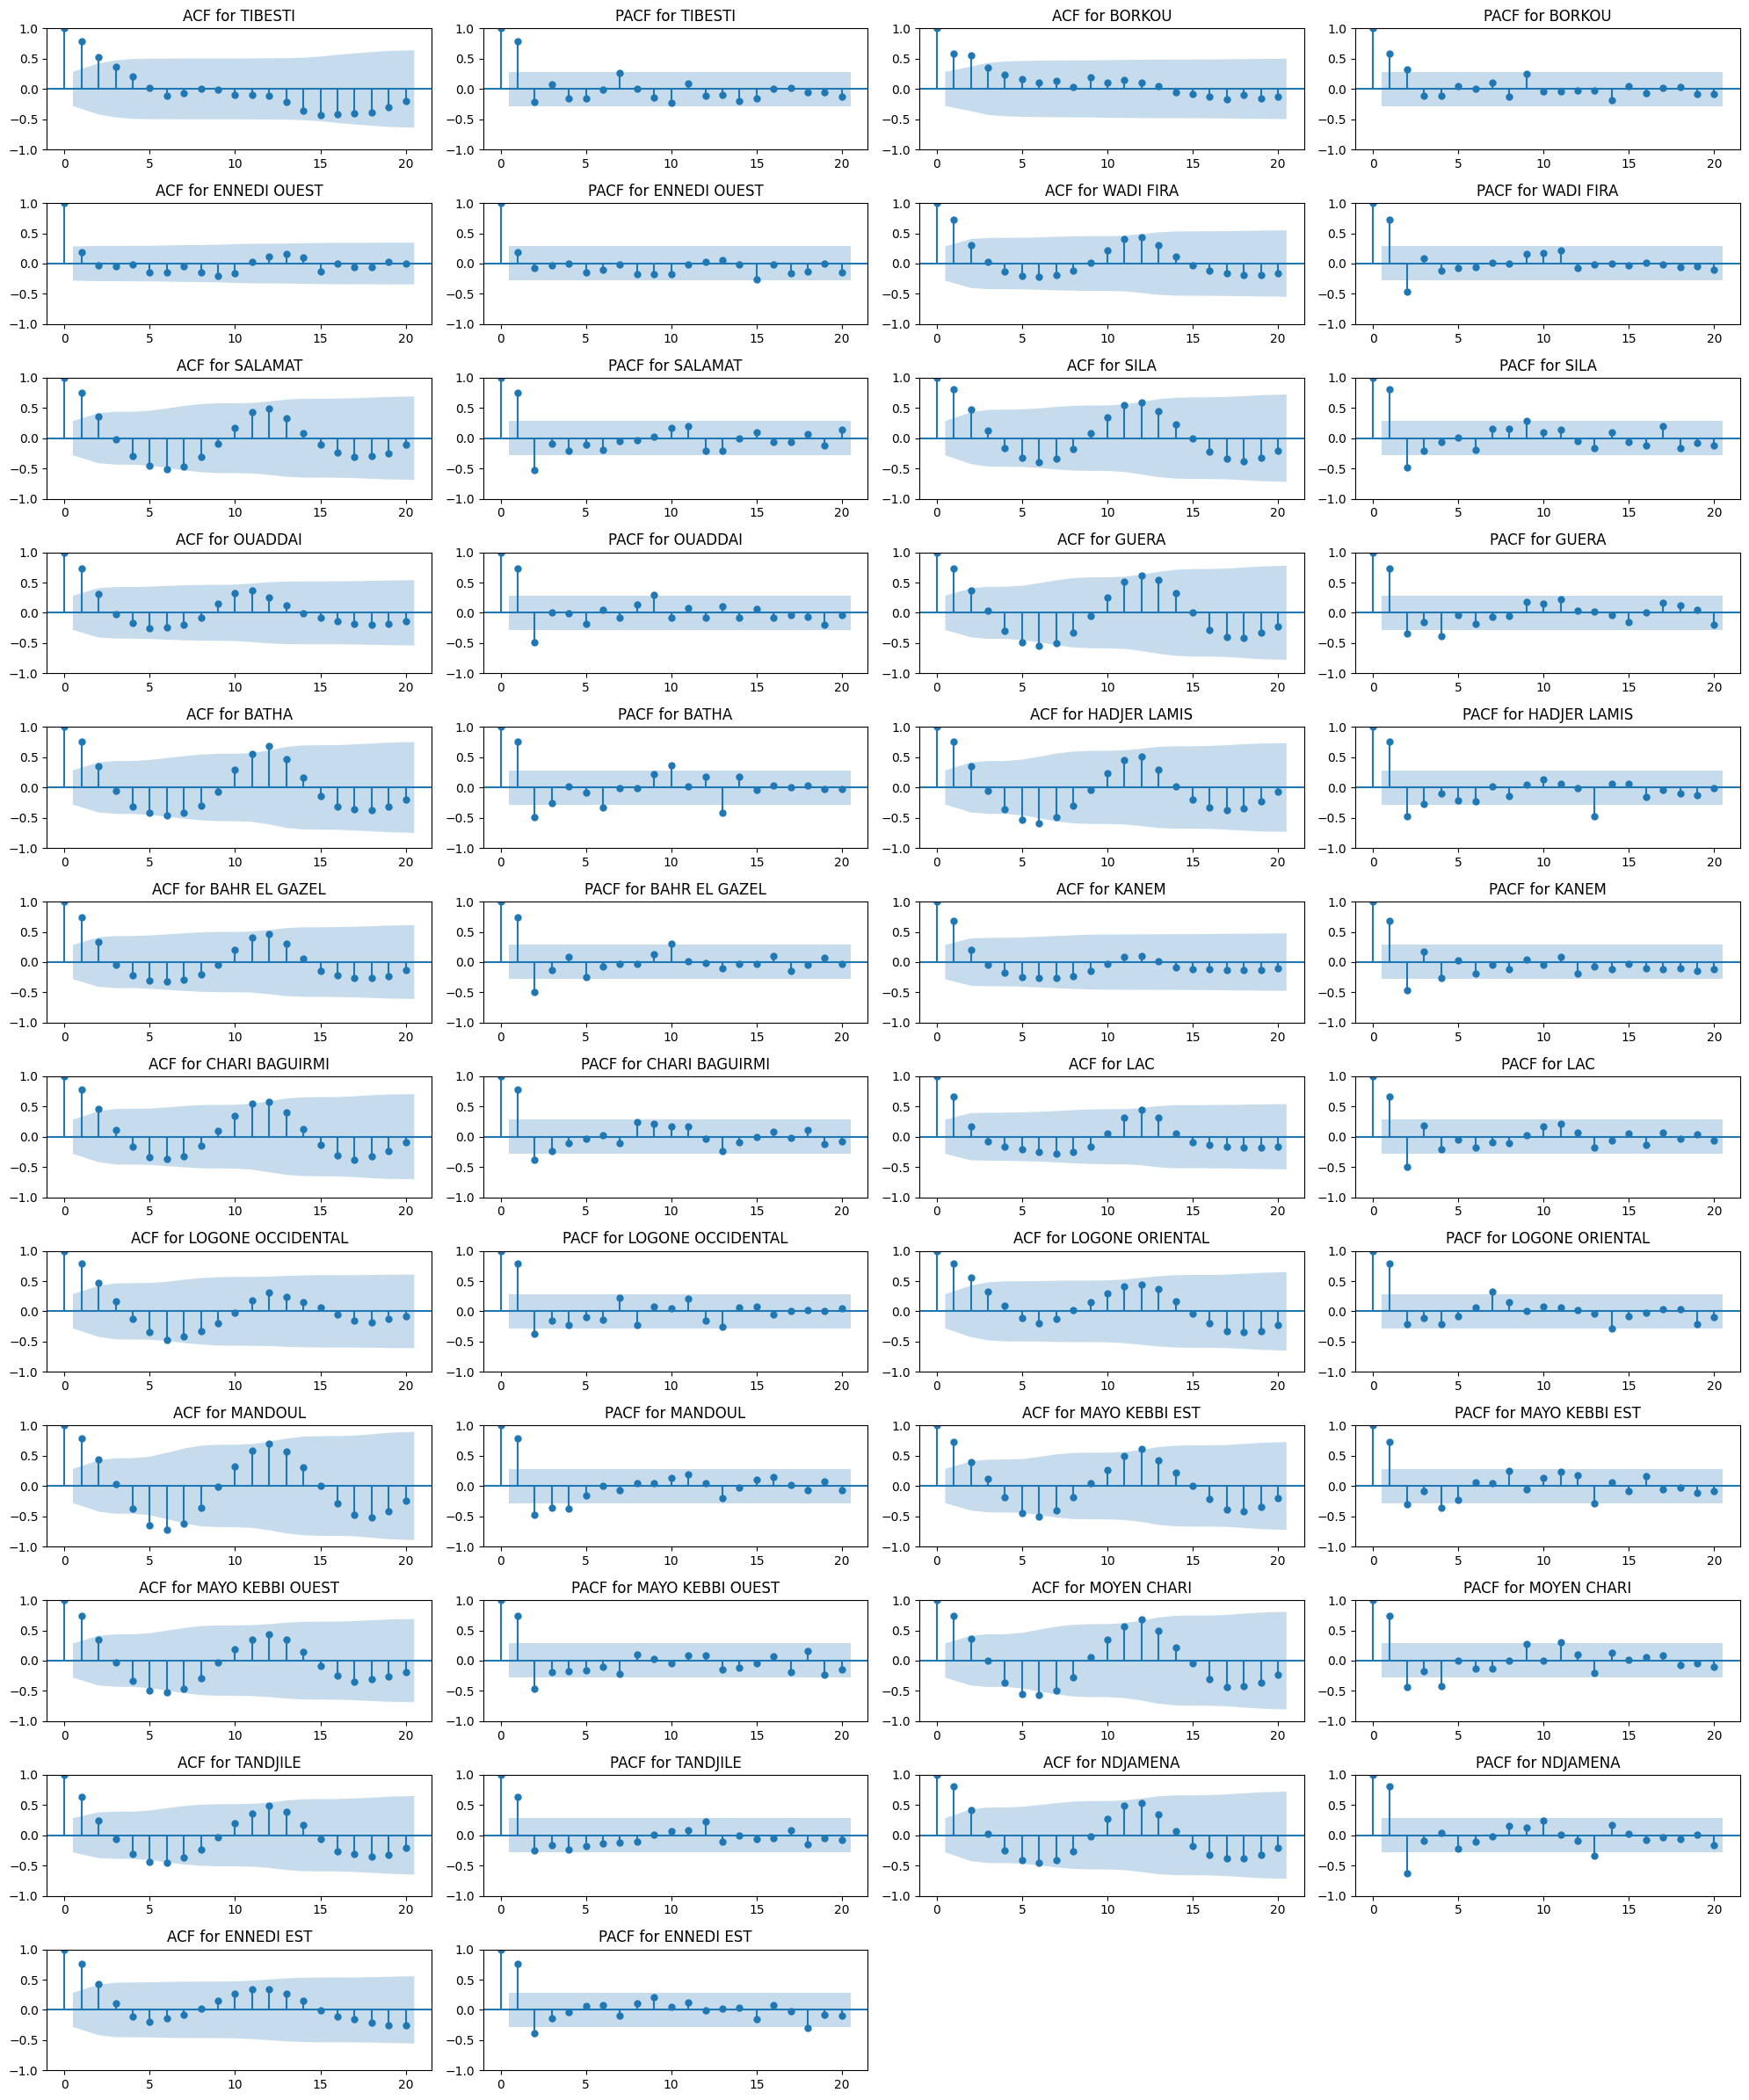

In [30]:
plt_acfs('cases', entities, nrows, ncols, data)

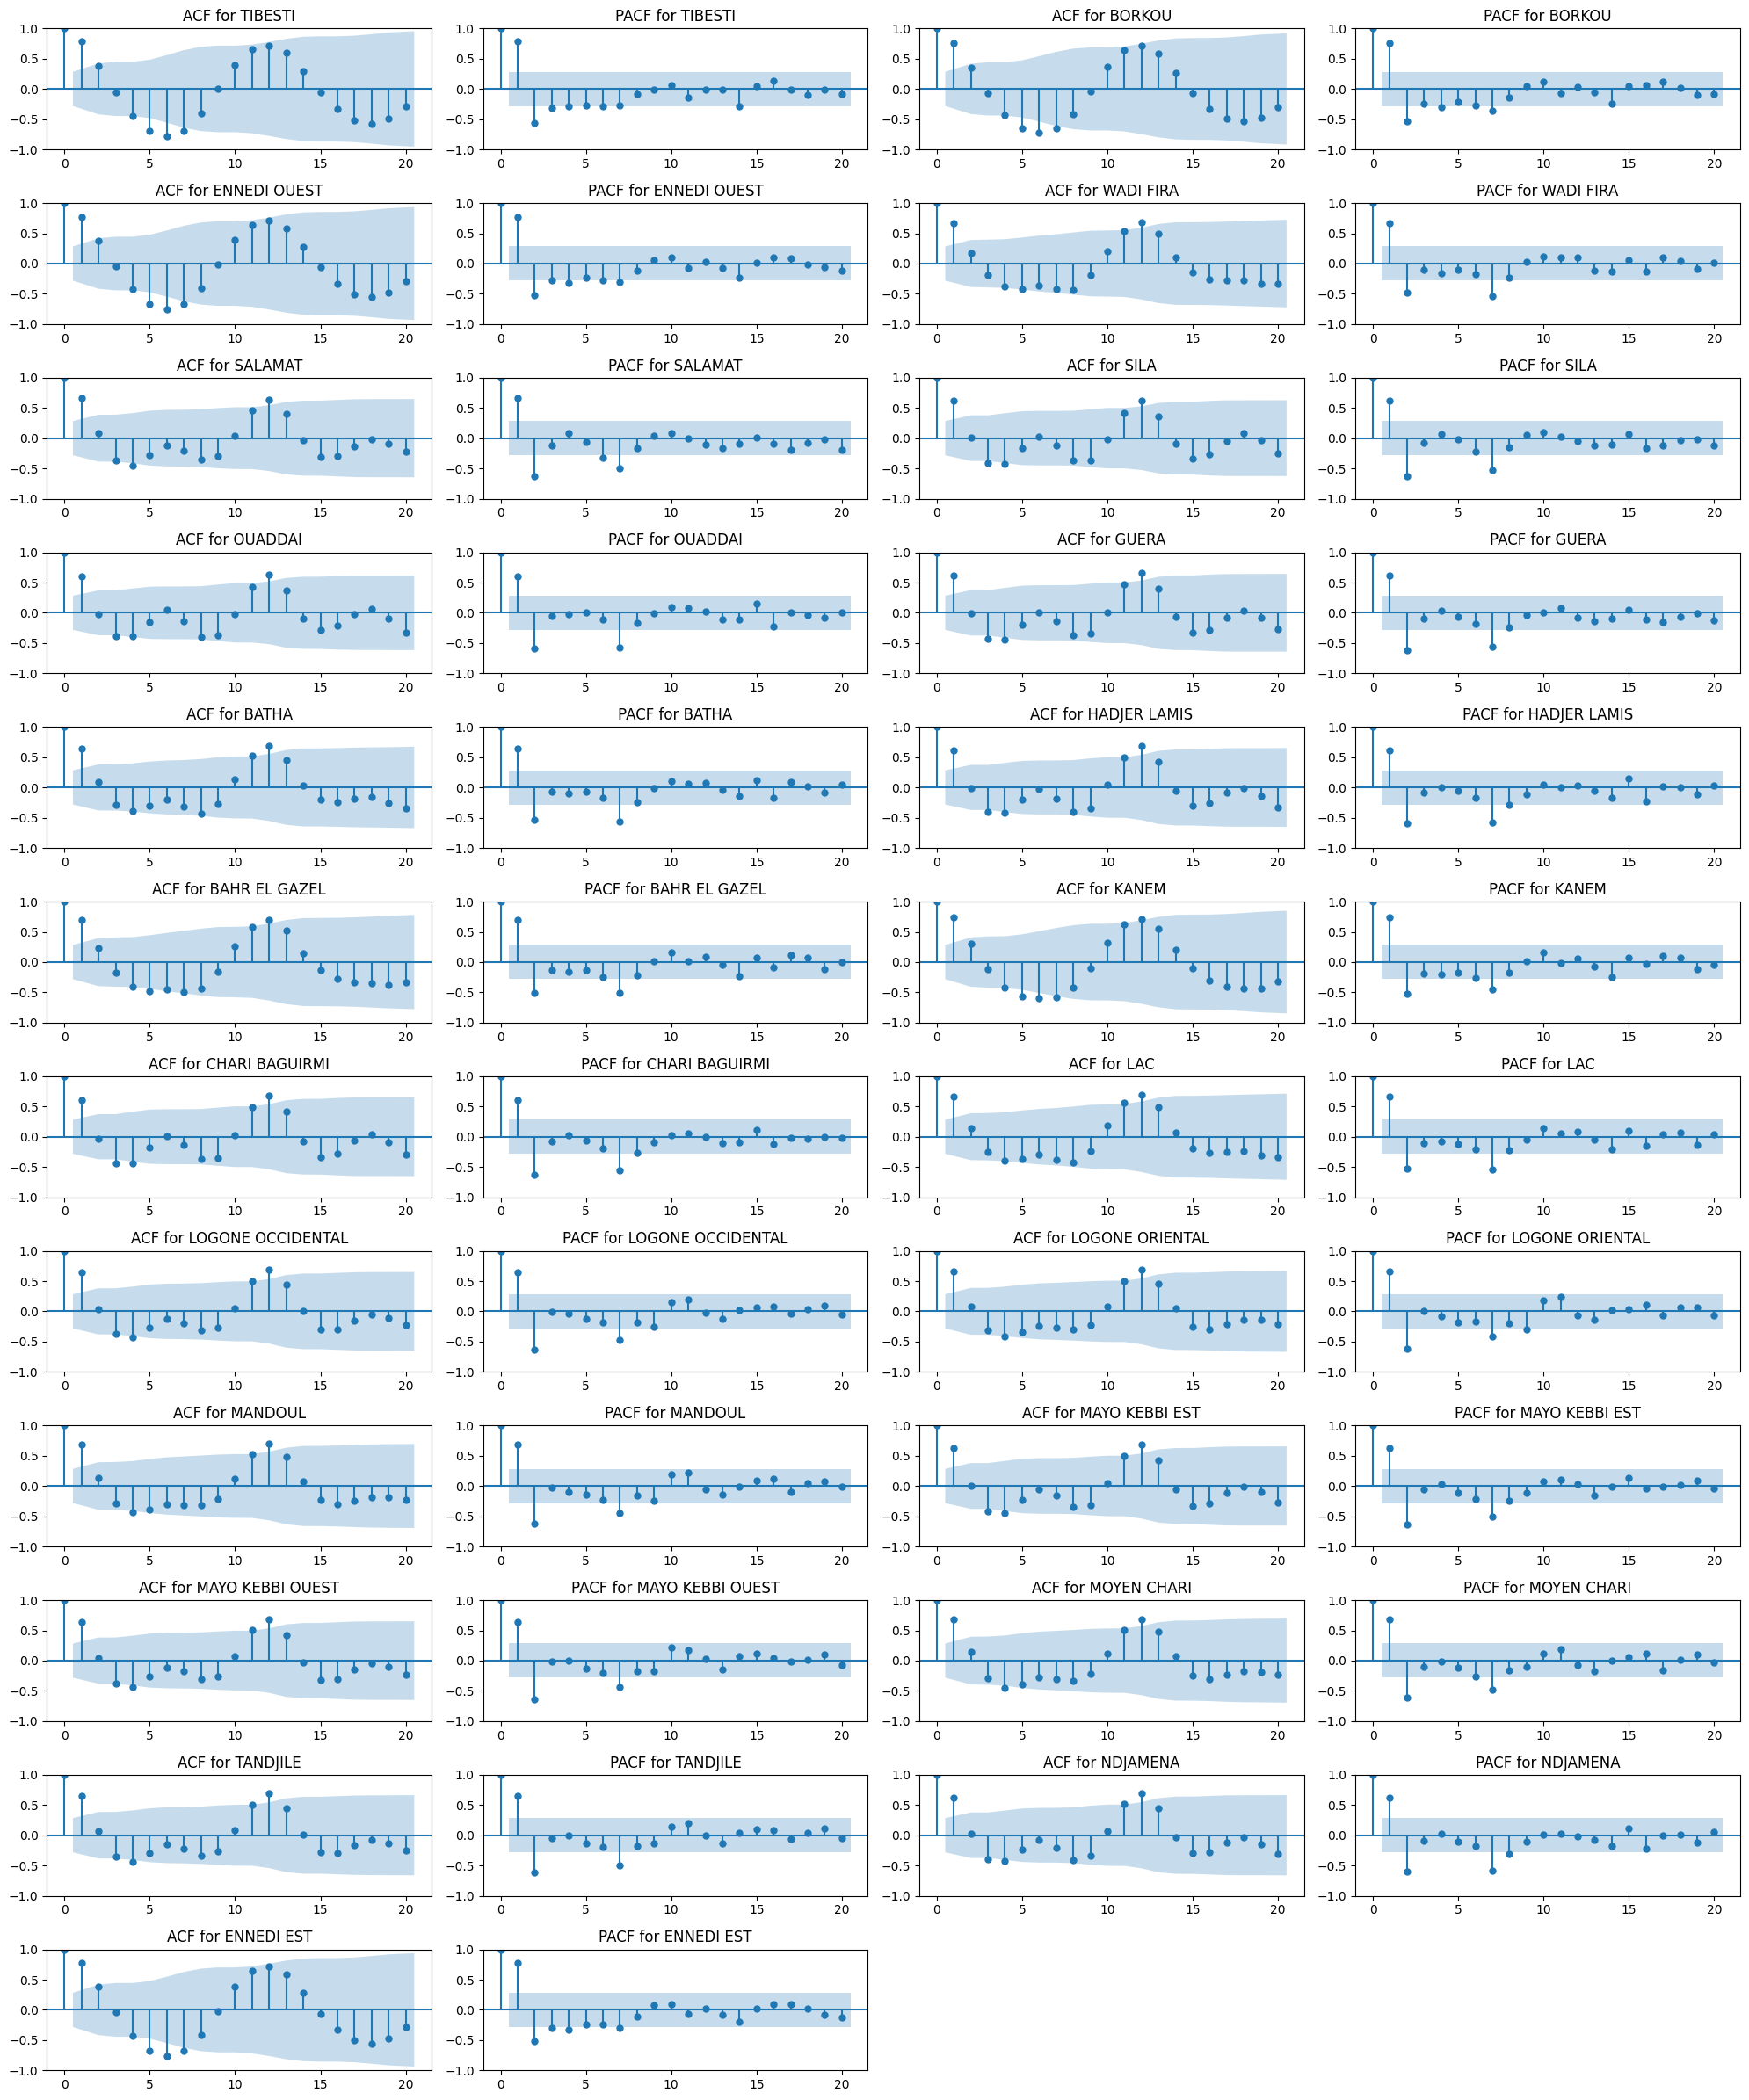

In [31]:
plt_acfs('t2m', entities, nrows, ncols, data)

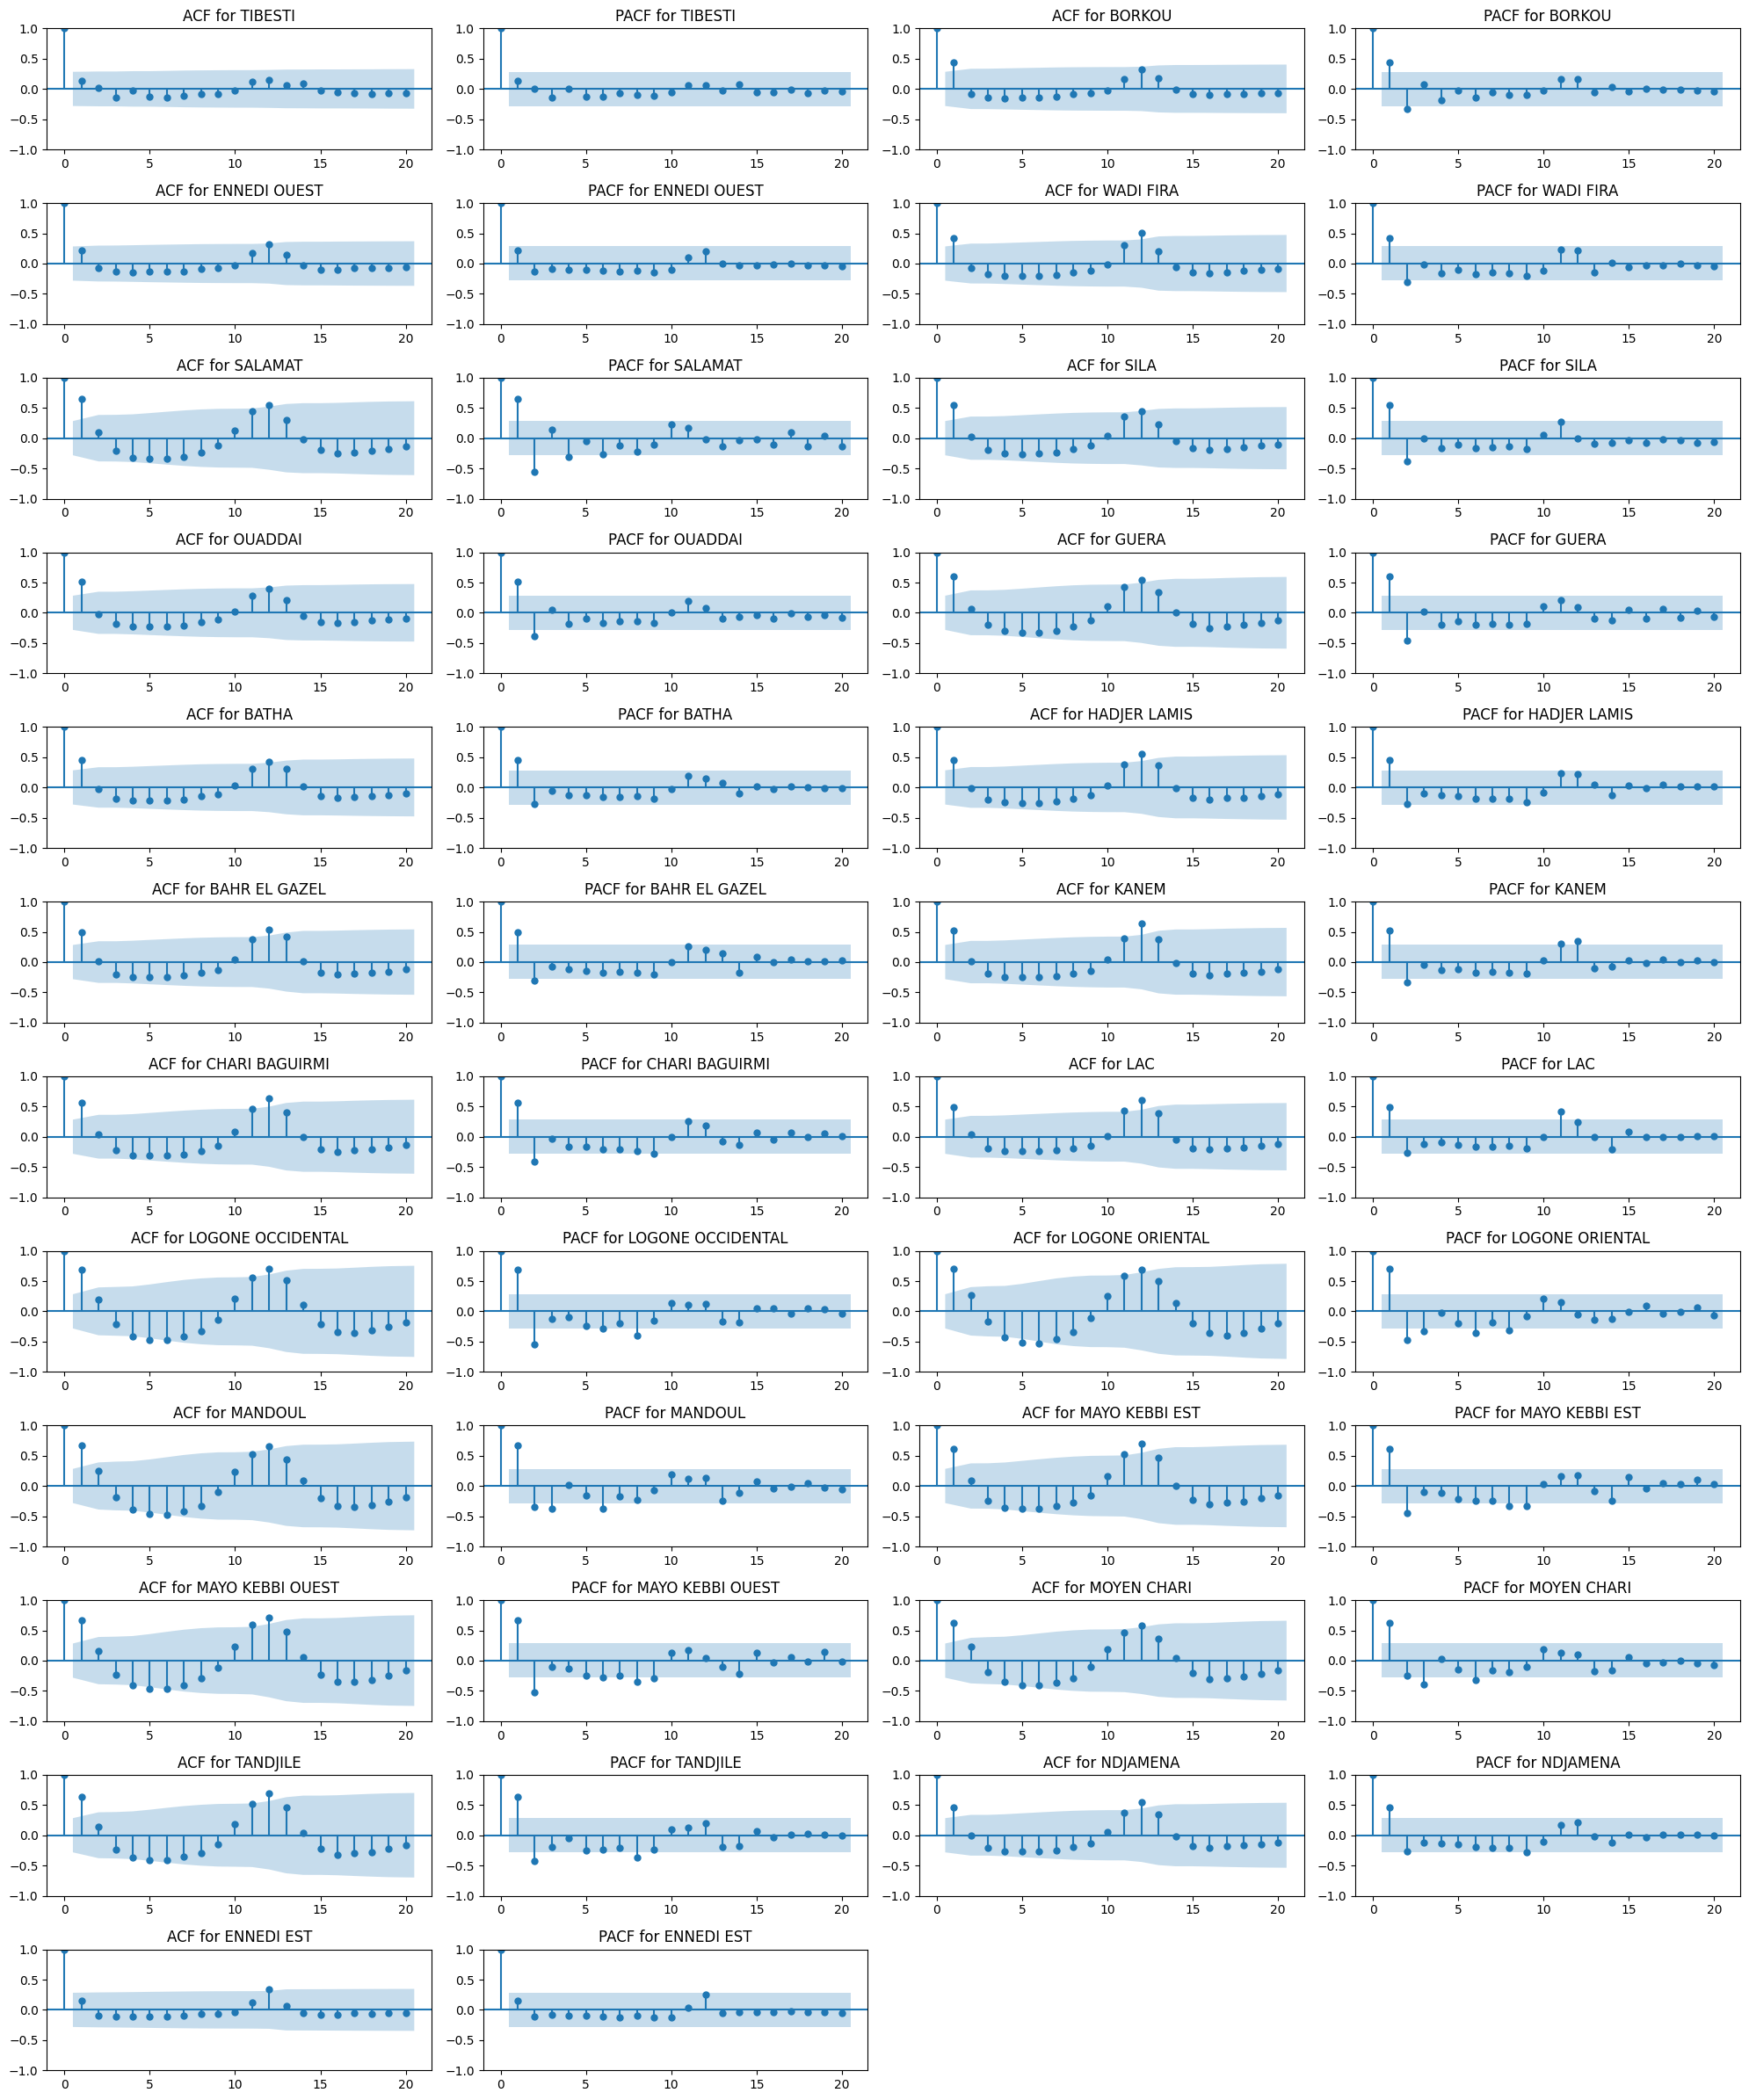

In [32]:
plt_acfs('tp', entities, nrows, ncols, data)

In [108]:
import pandas as pd
from  pydynpd import regression

command_str='cases L(1:2).cases t2m tp | gmm(t2m, 2:99) gmm(tp, 2:99)| nolevel collapse'
mydpd = regression.abond(command_str, data, ['state', 'time'])

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: state                            Number of obs = 1035     
 Time variable: time                              Min obs per group: 45    
 Number of instruments = 95                       Max obs per group: 45    
 Number of groups = 23                            Avg obs per group: 45.00 
+----------+--------------+---------------------+------------+-----------+-----+
|  cases   |    coef.     | Corrected Std. Err. |     z      |   P>|z|   |     |
+----------+--------------+---------------------+------------+-----------+-----+
| L1.cases |  0.1554223   |      0.0367909      | 4.2244721  | 0.0000240 | *** |
| L2.cases |  -0.0175567  |      0.0699419      | -0.2510188 | 0.8017995 |     |
|   t2m    | 855.5048868  |     350.6337752     | 2.4398816  | 0.0146921 |  *  |
|    tp    | 3058.8316950 |     1056.9598447    | 2.8939904  | 0.0038038 |  ** |
+----------+--------------+---------------------+------------+-----------

# OLS estimation

In [18]:
import pandas as pd
from linearmodels.panel import PanelOLS

data['time'] = pd.to_datetime(data['time']) 
data['region'] = data['state']
df = data.set_index(['state', 'time'])


# Drop rows with missing lagged values (from the first time period)
df = df.dropna()

# Define dependent and independent variables
y = df['cases']
X = df[['t2m', 'tp', 'year', 'month', 'region']]

# Fit dynamic panel model (Fixed effects)
model_ols = PanelOLS(y, X, entity_effects=True, time_effects=False, drop_absorbed=True)
results_ols = model_ols.fit()

# Display results
print(results_ols.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  cases   R-squared:                        0.4908
Estimator:                   PanelOLS   R-squared (Between):             -0.7505
No. Observations:                1104   R-squared (Within):               0.4908
Date:                Wed, Sep 18 2024   R-squared (Overall):             -0.4669
Time:                        15:12:59   Log-likelihood                -1.021e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      64.157
Entities:                          23   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                 F(16,1065)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):             64.157
                            

/tmp/ipykernel_22826/1318744822.py:18: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

region.BATHA, region.BORKOU, region.CHARI BAGUIRMI, region.ENNEDI EST, region.ENNEDI OUEST, region.GUERA, region.HADJER LAMIS, region.KANEM, region.LAC, region.LOGONE OCCIDENTAL, region.LOGONE ORIENTAL, region.MANDOUL, region.MAYO KEBBI EST, region.MAYO KEBBI OUEST, region.MOYEN CHARI, region.NDJAMENA, region.OUADDAI, region.SALAMAT, region.SILA, region.TANDJILE, region.TIBESTI, region.WADI FIRA

  results_ols = model_ols.fit()


In [19]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add a constant term to the independent variables
X_with_constant = sm.add_constant(X[['t2m', 'tp']])  # Adds a constant column for the intercept

# Get residuals from the fitted Random Effects model
residuals = results_ols.resids

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, X_with_constant)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


Breusch-Pagan Test: LM Statistic = 37.41512204769116, p-value = 7.506015855601077e-09


In [5]:
# Extract Fixed (Entity) Effects
fixed_effects = results_ols.estimated_effects
print("\nFixed Effects (Entity Effects):\n", fixed_effects)


Fixed Effects (Entity Effects):
                              estimated_effects
state            time                         
TIBESTI          2020-01-01        2432.866637
BORKOU           2020-01-01        3314.890753
ENNEDI OUEST     2020-01-01        2812.313736
WADI FIRA        2020-01-01        4413.816337
SALAMAT          2020-01-01        5144.639132
...                                        ...
MAYO KEBBI OUEST 2023-12-01        7211.623170
MOYEN CHARI      2023-12-01       12353.720417
TANDJILE         2023-12-01        9984.043558
NDJAMENA         2023-12-01       14409.187498
ENNEDI EST       2023-12-01        2628.786731

[1104 rows x 1 columns]


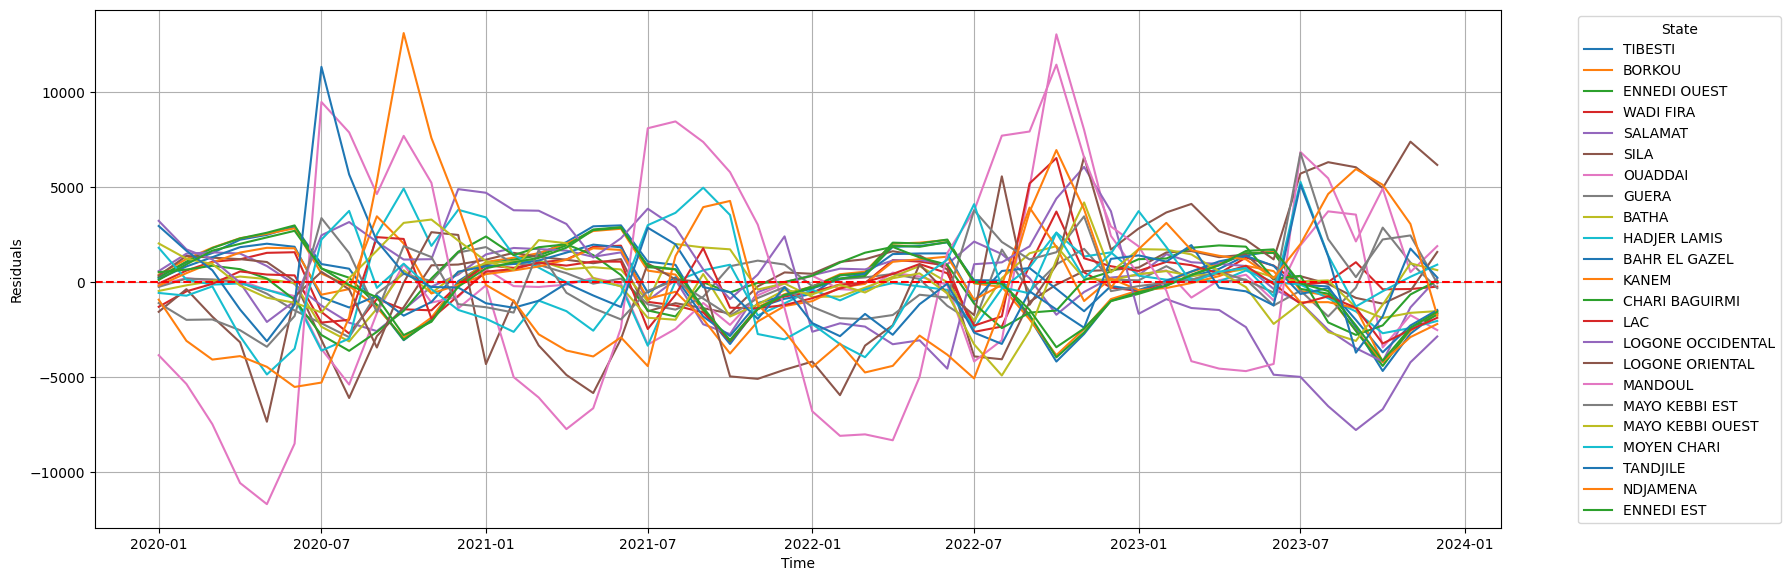

In [10]:
# Extract residuals
residuals = results_ols.resids

# Extract index levels: 'state' and 'time' (or whatever your index names are)
states = residuals.index.get_level_values(0)  # State level (first level)
time = residuals.index.get_level_values(1)  # Time level (second level)

# Convert residuals to DataFrame for easier plotting
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'state': states,
    'time': time
})

# Plot residuals for each state using a line plot
plt.figure(figsize=(18, 6))
for state in residuals_df['state'].unique():
    state_residuals = residuals_df[residuals_df['state'] == state]
    plt.plot(state_residuals['time'], state_residuals['residuals'], label=state)

# Customize the plot
plt.axhline(0, color='r', linestyle='--')
# plt.title('Residuals Over Time by State')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()

# Show the plot
plt.grid(True)

# Random Effects

In [31]:
import pandas as pd
from linearmodels.panel import RandomEffects

data['time'] = pd.to_datetime(data['time']) 
data['region'] = data['state']
df = data.set_index(['state', 'time'])


# Drop rows with missing lagged values (from the first time period)
df = df.dropna()

# Define dependent and independent variables
y = np.log(1+df['cases'])
X = df[['t2m', 'tp', 'year', 'month', 'region']]
X['t2m'] = np.log(X['t2m'])
X['tp'] = np.log(100*X['tp'])

model_random = RandomEffects(y, X) 
results_random = model_random.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_random.summary)

/tmp/ipykernel_22826/2327543025.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['t2m'] = np.log(X['t2m'])
/tmp/ipykernel_22826/2327543025.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['tp'] = np.log(100*X['tp'])


                        RandomEffects Estimation Summary                        
Dep. Variable:                  cases   R-squared:                        0.9940
Estimator:              RandomEffects   R-squared (Between):              1.0000
No. Observations:                1104   R-squared (Within):               0.4590
Date:                Wed, Sep 18 2024   R-squared (Overall):              0.9940
Time:                        15:23:08   Log-likelihood                   -1001.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4611.5
Entities:                          23   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                 F(38,1066)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):          4.177e+17
                            

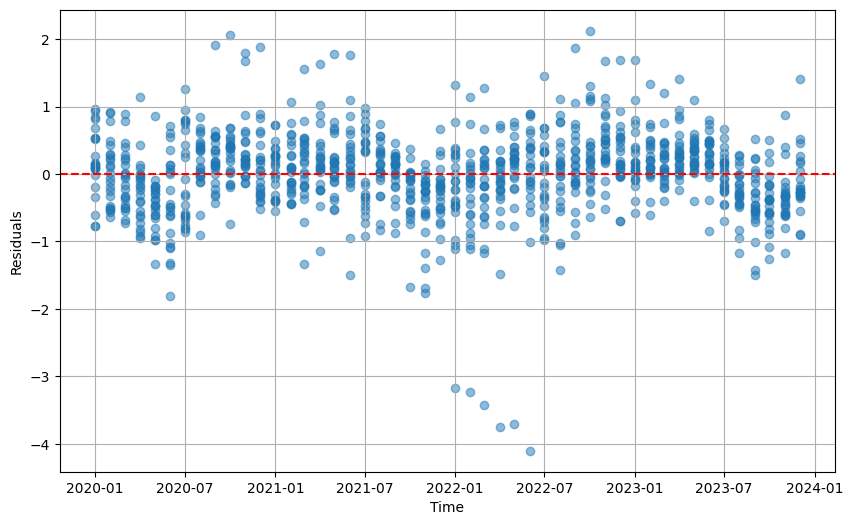

In [32]:
# Extract residuals
residuals = results_random.resids

# Create a residuals plot
plt.figure(figsize=(10,6))

# Option 1: Using Matplotlib
plt.scatter(residuals.index.get_level_values(1), residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

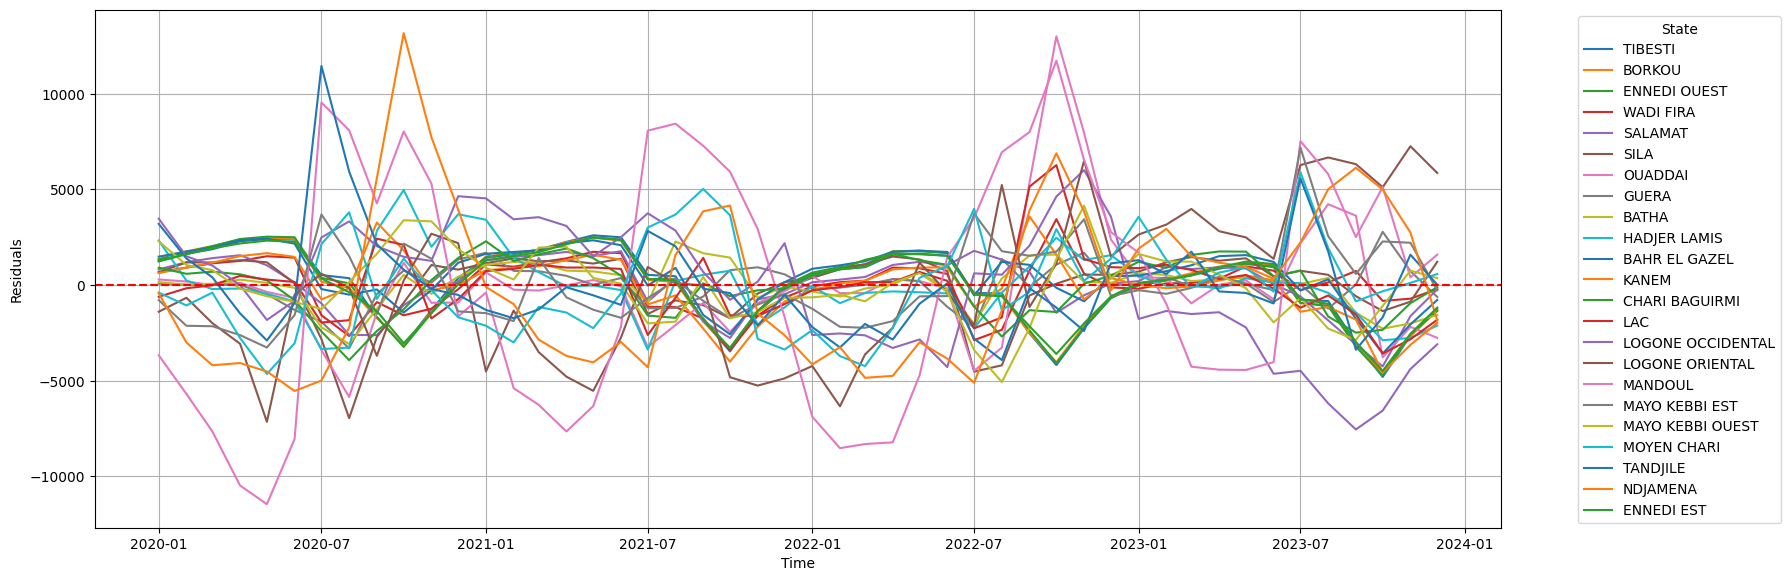

In [22]:
# Extract residuals
residuals = results_random.resids

# Extract index levels: 'state' and 'time' (or whatever your index names are)
states = residuals.index.get_level_values(0)  # State level (first level)
time = residuals.index.get_level_values(1)  # Time level (second level)

# Convert residuals to DataFrame for easier plotting
residuals_df = pd.DataFrame({
    'residuals': residuals,
    'state': states,
    'time': time
})

# Plot residuals for each state using a line plot
plt.figure(figsize=(18, 6))
for state in residuals_df['state'].unique():
    state_residuals = residuals_df[residuals_df['state'] == state]
    plt.plot(state_residuals['time'], state_residuals['residuals'], label=state)

# Customize the plot
plt.axhline(0, color='r', linestyle='--')
# plt.title('Residuals Over Time by State')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()

# Show the plot
plt.grid(True)
plt.savefig('../../docs/residuals.png', format='png', bbox_inches='tight', pad_inches=0)
plt.show()

In [8]:
X[['t2m', 'tp']]

,,t2m,tp
state,time,,
TIBESTI,2020-01-01,13.226863,0.006183
BORKOU,2020-01-01,17.938311,0.001743
ENNEDI OUEST,2020-01-01,14.834963,0.001229
WADI FIRA,2020-01-01,18.471732,0.001052
SALAMAT,2020-01-01,25.261679,0.001052
...,...,...,...
MAYO KEBBI OUEST,2023-12-01,26.830964,0.000435
MOYEN CHARI,2023-12-01,27.814579,0.000619
TANDJILE,2023-12-01,26.699490,0.000435


## Model validation
To properly validate the random effects model for homoscedasticity and no autocorrelation assumptions.
* Breusch-Pagan Test checks for heteroscedasticity in residuals.
* Durbin-Watson Test checks for first-order autocorrelation.
* Breusch-Godfrey Test checks for higher-order autocorrelation.

In [33]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add a constant term to the independent variables
X_with_constant = sm.add_constant(X[['t2m', 'tp']])  # Adds a constant column for the intercept

# Get residuals from the fitted Random Effects model
residuals = results_random.resids

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, X_with_constant)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


Breusch-Pagan Test: LM Statistic = 21.18865629092773, p-value = 2.5057731246298692e-05


In [7]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Get the residuals from your model (Random Effects model or any model)
residuals = results_random.resids
exog = X[['t2m', 'tp']]  # Explanatory variables (independent variables)

# Breusch-Pagan test for heteroscedasticity
bp_test = het_breuschpagan(residuals, exog)

# The test returns: Lagrange multiplier statistic, p-value, f-value, f p-value
bp_lm_stat, bp_lm_pvalue, f_value, f_pvalue = bp_test
print(f"Breusch-Pagan Test: LM Statistic = {bp_lm_stat}, p-value = {bp_lm_pvalue}")


ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [9]:
from statsmodels.stats.stattools import durbin_watson

# Get residuals from your model
residuals = results_random.resids

# Perform Durbin-Watson test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic = {dw_stat}")


Durbin-Watson statistic = 1.5152948617090316


The value of the Durbin-Watson statistic ranges from 0 to 4:
* A value close to 2 indicates no autocorrelation.
* A value closer to 0 suggests positive autocorrelation.
* A value closer to 4 suggests negative autocorrelation.

In [11]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# Breusch-Godfrey test for autocorrelation
bg_test = acorr_breusch_godfrey(results_random, nlags=2)  # Specify the number of lags
bg_lm_stat, bg_lm_pvalue, f_value, f_pvalue = bg_test
print(f"Breusch-Godfrey Test: LM Statistic = {bg_lm_stat}, p-value = {bg_lm_pvalue}")


AttributeError: 'RandomEffectsResults' object has no attribute 'resid'

# Test for individual random effects (Hausman)

In [100]:
from scipy import stats

# 3. Extract coefficients and covariance matrices
beta_fixed = results_ols.params
beta_random = results_random.params

cov_fixed = results_ols.cov
cov_random = results_random.cov

# 4. Compute the Hausman test statistic
diff = beta_fixed - beta_random
chi2_stat = np.dot(np.dot(diff.T, np.linalg.inv(cov_fixed - cov_random)), diff)
p_value = stats.chi2.sf(chi2_stat, df=len(diff))

# Display the results
print(f"Hausman test statistic: {chi2_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject null hypothesis: Fixed Effects model is preferred.")
else:
    print("Fail to reject null hypothesis: Random Effects model is preferred.")


Hausman test statistic: 62.51834025536211
P-value: 1.7023383371844174e-13
Reject null hypothesis: Fixed Effects model is preferred.


In [101]:
results_random.estimated_effects

,,estimated_effects
state,time,
TIBESTI,2020-02-01,0.0
BORKOU,2020-02-01,0.0
ENNEDI OUEST,2020-02-01,0.0
WADI FIRA,2020-02-01,0.0
SALAMAT,2020-02-01,0.0
...,...,...
MAYO KEBBI OUEST,2023-12-01,0.0
MOYEN CHARI,2023-12-01,0.0
TANDJILE,2023-12-01,0.0


In [63]:
results_random.df_resid

1078

In [90]:
from linearmodels.panel import compare
from linearmodels.panel import PanelOLS

# Compare the random effects and fixed effects models
comparison = compare({"Random Effects": results_random, "Fixed Effects": results_ols})
print(comparison)

                    Model Comparison                    
                           Random Effects  Fixed Effects
--------------------------------------------------------
Dep. Variable                       cases          cases
Estimator                   RandomEffects       PanelOLS
No. Observations                     1081           1081
Cov. Est.                      Unadjusted     Unadjusted
R-squared                          0.9233         0.6973
R-Squared (Within)                 0.6817         0.6973
R-Squared (Between)                0.9948         0.9779
R-Squared (Overall)                0.9233         0.9139
F-statistic                        4326.8         810.12
P-value (F-stat)                   0.0000         0.0000
=====================     ===============   ============
cases_lag                          0.8479         0.7257
                                 (74.053)       (41.504)
t2m                                6.2978         18.123
                               

# GMM estimation

In [36]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM


In [37]:
gmm_model = GMM(y, X, weights=True)
gmm_res = gmm_model.fit()
print(gmm_res.summary)


TypeError: GMM.__init__() missing 1 required positional argument: 'instrument'